# Extração da característica de relação sinal-ruído de dados de EEG

A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [2]:

# Criando dados fictícios
# pensando em um vídeo de 10 minutos, com uma taxa de amostragem de 250 Hz
#   teremos 10 * 60 * 250 = 150.000 amostras (sinal com foco)
#   teremos 1 * 60 * 250 = 15.000 amostras (basal)

# imports de bibliotecas

import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

basal = '../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt'
basal_ob = np.loadtxt(basal, delimiter=',', skiprows=5, usecols=range(1, 9)).astype(np.float32)
data_noise_basal = basal_ob[1250:37500,:]    # 30 segundos de basal
data_amostra = basal_ob[1250:15000,:]      # 5 minutos de amostra

shape = (150000, 8)
data_focus = np.random.normal(loc=0, scale=10, size=shape).astype(np.float32)

shape = (15000, 8)
data_base = np.random.normal(loc=0, scale=10, size=shape).astype(np.float32)


data_amostra_mne = mne.io.RawArray(data_amostra.T, info)
data_amostra_mne.notch_filter(freqs=60)
data_amostra_mne.filter(l_freq=4, h_freq=100)

data_noise_basal_mne = mne.io.RawArray(data_noise_basal.T, info)
data_noise_basal_mne.notch_filter(freqs=60)
data_noise_basal_mne.filter(l_freq=4, h_freq=100)



Creating RawArray with float64 data, n_channels=8, n_times=13750
    Range : 0 ... 13749 =      0.000 ...    54.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,4.00 Hz
Lowpass,100.00 Hz


In [3]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# armazena uma lista com as médias de potência para cada canal
noise_power = []
for channel_data in data_noise_basal.T:
    fft_result = np.fft.fft(channel_data)
    # densidade espectral de potência (PSD)
    psd = np.abs(fft_result) ** 2
    # média da potência no intervalo de tempo sem estímulo
    base_power = np.mean(psd)
    noise_power.append(base_power)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = np.mean(noise_power)
print(estimated_background_noise)


51663398248351.55


[38, 0, 0, 17]
17
38
0


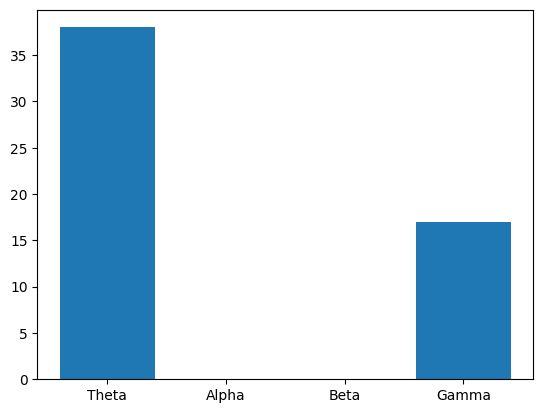

In [4]:
tamanho_amostra = 5 * 60 * 250
tamanho_buffer = 5 * 250
jump = 1 * 250
overlap = 4 * 250

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

# criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []

sr = 250            # taxa de amostragem
jump = 3            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados



total_pc = {}
results = [0, 0, 0, 0]
for i in range(0, data_amostra_mne.n_times, 250):
    if i + size < data_amostra_mne.n_times:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[i]+jump)
    else:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[-1])  
    # Número de pontos por segmento
    nperseg = 128
    # Quantidade de sobreposição entre segmentos
    noverlap = nperseg // 2
    #cut.set_eeg_reference(ref_channels='average')
    cut = cut.get_data()

    

    # realizando a média dos 8 eletrodos
    # no caso do trabalho, analizar os canais separadamente.
    #   Para isso, vamos aplicar o filtro espacial, no qual
    #   podemos utilizar algoritmos específicos para a análise
    #   de EEG utilizando o CAR (Common Average Reference).

    freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
    X = np.average(psd, axis=0)

    # Encontrar os índices correspondentes às frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Calcular a potência em cada banda de frequência por meio da integração da PSD
    bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
    # calculando a pontuação de cada banda para mostrar a porcentagem futura
    results[np.argmax(bands)] += 1
    if np.argmax(bands) == 2 or np.argmax(bands) == 3:
        amostras_alvo.append(cut)
    elif np.argmax(bands) == 0:
        amostras_theta.append(cut)
    else:
        amostras_descarte.append(cut)
print(results)
plot = plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)

print(len(amostras_alvo))
print(len(amostras_theta))
print(len(amostras_descarte))